In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/cst.csv').drop(['fyear', 'gvkey'], axis = 1)
df['caldt'] = pd.to_datetime(df['caldt'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356276 entries, 0 to 356275
Data columns (total 32 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   permno  356276 non-null  int64         
 1   caldt   356276 non-null  datetime64[ns]
 2   act     258623 non-null  float64       
 3   ap      290512 non-null  float64       
 4   at      308384 non-null  float64       
 5   capx    286360 non-null  float64       
 6   ceq     299447 non-null  float64       
 7   che     305517 non-null  float64       
 8   cogs    305690 non-null  float64       
 9   dlc     304580 non-null  float64       
 10  dltt    307076 non-null  float64       
 11  dp      294548 non-null  float64       
 12  dvp     307580 non-null  float64       
 13  ebit    297422 non-null  float64       
 14  ebitda  299870 non-null  float64       
 15  emp     287233 non-null  float64       
 16  ib      307900 non-null  float64       
 17  invt    299551 non-null  floa

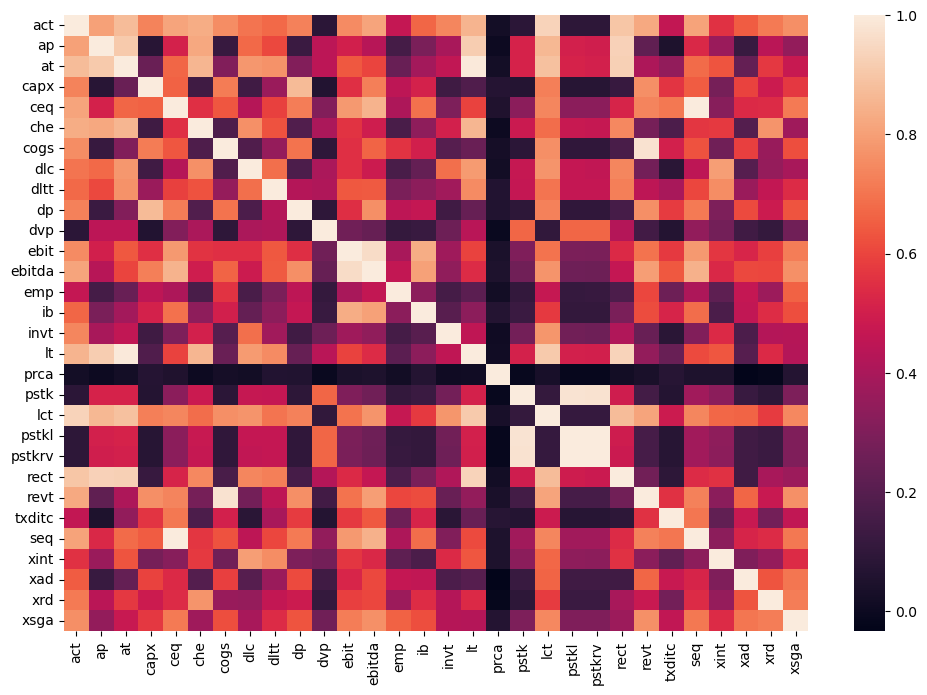

In [3]:
plt.rcParams["figure.figsize"] = (12, 8)
sns.heatmap(df.drop(['permno', 'caldt'], axis = 1).corr(), annot = False)
plt.show()

In [4]:
# Holy collinearity Batman!
# But who cares. Let's try to make some interesting value-weighted portfolios.

"""
IDEAS: Maybe a portfolio of stocks with high interest, advertising, and research and development expenses relative to their assets?
xint       interest expense
xad        advertising expense
xrd        research and development expense
at         total assets
invst      (xint + xad + xrd) / at

Maybe a portfolio of efficient firms in terms of their cost of goods sold, and their sales and administrative expenses relative to their assets?
cogs       cost of goods sold
xsga       selling, general, and administrative expense
effc       (at - cogs - xsga) / at
:::::
:::::
:::::
STANDARD ACCOUNTING RATIOS:

Maybe a portfolio formed by the firms quick ratio?
act        current assets - total
invt       inventories - total
lct        current liabilities - total
quick      (act - invt) / lct

Maybe the return on equity?
revt       revenue - total
xint       interest expense
xad        advertising expense
xrd        research and development expense
xsga       selling, general, and administrative expense
seq        stockholders equity - total
roe        (revt - xint - xad - xrd - xsga) / seq

Maybe the fixed asset turnover?
act        current assets - total
at         total assets
fat        revt / (at - act)

Maybe the Debt Ratio?
dltt         long-term debt
dlc          current liabilities
at           total assets
debt_ratio   (dltt + dlc) / at
""";

In [5]:
df['invst'] = (df['xint'] + df['xad'] + df['xrd']) / df['at']
df['effc'] = (df['at'] - df['cogs'] - df['xsga']) / df['at']
df['quick'] = (df['act'] - df['invt']) / df['lct']
df['roe'] = (df['revt'] - df['xint'] - df['xad'] - df['xrd'] - df['xsga']) / df['seq']
df['fat'] = df['revt'] / (df['at'] - df['act'])
df['debt_ratio'] = (df['dltt'] + df['dlc']) / df['at']

In [6]:
factors = ['invst', 'effc', 'quick', 'roe', 'fat', 'debt_ratio']
f_df = df[factors + ['permno', 'caldt']]
f_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356276 entries, 0 to 356275
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   invst       53763 non-null   float64       
 1   effc        254873 non-null  float64       
 2   quick       255309 non-null  float64       
 3   roe         51052 non-null   float64       
 4   fat         257995 non-null  float64       
 5   debt_ratio  303979 non-null  float64       
 6   permno      356276 non-null  int64         
 7   caldt       356276 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 21.7 MB


In [7]:
# We must avoid look-ahead bias.
f_df.sort_values(['permno', 'caldt'], inplace = True)
f_df['invst_lag'] = f_df.groupby('permno')['invst'].shift(1)
f_df['effc_lag'] = f_df.groupby('permno')['effc'].shift(1)
f_df['quick_lag'] = f_df.groupby('permno')['quick'].shift(1)
f_df['roe_lag'] = f_df.groupby('permno')['roe'].shift(1)
f_df['fat_lag'] = f_df.groupby('permno')['fat'].shift(1)
f_df['debt_ratio_lag'] = f_df.groupby('permno')['debt_ratio'].shift(1)
f_df.drop(['invst', 'effc', 'quick', 'roe', 'fat', 'debt_ratio'], axis = 1, inplace = True)
f_df.info(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 356276 entries, 166142 to 348188
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   permno          356276 non-null  int64         
 1   caldt           356276 non-null  datetime64[ns]
 2   invst_lag       49115 non-null   float64       
 3   effc_lag        232944 non-null  float64       
 4   quick_lag       233904 non-null  float64       
 5   roe_lag         46688 non-null   float64       
 6   fat_lag         236470 non-null  float64       
 7   debt_ratio_lag  278345 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 24.5 MB


In [8]:
# There are a lot of missing values. We want to drop them, but one at a time. Let's merge in the returns first:
ret = pd.read_feather('data/crsp_monthly.ftr', columns = ['permno', 'caldt', 'ret', 'prc', 'shr'])
ret['me'] = ret['prc'] * ret['shr']
ret['me_lag'] = ret.groupby('permno')['me'].shift(1)
f_df = pd.merge(f_df, ret, on = ['permno', 'caldt'], how = 'inner')
f_df = f_df.query('me_lag > 0').drop(['me', 'prc', 'shr'], axis = 1)
f_df.head(3)

,permno,caldt,invst_lag,effc_lag,quick_lag,roe_lag,fat_lag,debt_ratio_lag,ret,me_lag
4,10001,1989-06-30,NaN,NaN,0.994720,NaN,1.741691,0.245420,0.017143,6986.000
7,10001,1994-06-30,NaN,NaN,1.054087,NaN,1.336478,0.463403,0.107302,17183.250
9,10001,1997-06-30,NaN,NaN,0.572511,NaN,1.136027,0.479242,-0.030725,20329.125


In [9]:
f_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213357 entries, 4 to 251932
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   permno          213357 non-null  int64         
 1   caldt           213357 non-null  datetime64[ns]
 2   invst_lag       28607 non-null   float64       
 3   effc_lag        140486 non-null  float64       
 4   quick_lag       141736 non-null  float64       
 5   roe_lag         27354 non-null   float64       
 6   fat_lag         143521 non-null  float64       
 7   debt_ratio_lag  168670 non-null  float64       
 8   ret             213299 non-null  float64       
 9   me_lag          213357 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 17.9 MB


In [10]:
# Time to create separate dataframes for each factor:
invst_df = f_df[['permno', 'caldt', 'invst_lag', 'ret', 'me_lag']]
invst_df.dropna(inplace = True, axis = 0)

effc_df = f_df[['permno', 'caldt', 'effc_lag', 'ret', 'me_lag']]
effc_df.dropna(inplace = True, axis = 0)

quick_df = f_df[['permno', 'caldt', 'quick_lag', 'ret', 'me_lag']]
quick_df.dropna(inplace = True, axis = 0)

roe_df = f_df[['permno', 'caldt', 'roe_lag', 'ret', 'me_lag']]
roe_df.dropna(inplace = True, axis = 0)

fat_df = f_df[['permno', 'caldt', 'fat_lag', 'ret', 'me_lag']]
fat_df.dropna(inplace = True, axis = 0)

debt_ratio_df = f_df[['permno', 'caldt', 'debt_ratio_lag', 'ret', 'me_lag']]
debt_ratio_df.dropna(inplace = True, axis = 0)

# Now we can create the portfolios:
invst_df['bins'] = invst_df.groupby('caldt')['invst_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')

effc_df['bins'] = effc_df.groupby('caldt')['effc_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')

quick_df['bins'] = quick_df.groupby('caldt')['quick_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')

roe_df['bins'] = roe_df.groupby('caldt')['roe_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')

fat_df['bins'] = fat_df.groupby('caldt')['fat_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')

debt_ratio_df['bins'] = debt_ratio_df.groupby('caldt')['debt_ratio_lag'].transform(pd.qcut,5,labels=False, duplicates='drop')

In [ ]:
# Time to compute the value-weights for each portfolio:
invst_mcap_sum = invst_df.groupby(['caldt', 'bins'])['me_lag'].sum()
effc_mcap_sum = effc_df.groupby(['caldt', 'bins'])['me_lag'].sum()
quick_mcap_sum = quick_df.groupby(['caldt', 'bins'])['me_lag'].sum()
roe_mcap_sum = roe_df.groupby(['caldt', 'bins'])['me_lag'].sum()
fat_mcap_sum = fat_df.groupby(['caldt', 'bins'])['me_lag'].sum()
debt_ratio_mcap_sum = debt_ratio_df.groupby(['caldt', 'bins'])['me_lag'].sum()

invst_df['rme'] = invst_df['ret'] * invst_df['me_lag']
effc_df['rme'] = effc_df['ret'] * effc_df['me_lag']
quick_df['rme'] = quick_df['ret'] * quick_df['me_lag']
roe_df['rme'] = roe_df['ret'] * roe_df['me_lag']
fat_df['rme'] = fat_df['ret'] * fat_df['me_lag']
debt_ratio_df['rme'] = debt_ratio_df['ret'] * debt_ratio_df['me_lag']

invst_vw = invst_df.groupby(['caldt', 'bins'])['rme'].sum() / invst_mcap_sum
effc_vw = effc_df.groupby(['caldt', 'bins'])['rme'].sum() / effc_mcap_sum
quick_vw = quick_df.groupby(['caldt', 'bins'])['rme'].sum() / quick_mcap_sum
roe_vw = roe_df.groupby(['caldt', 'bins'])['rme'].sum() / roe_mcap_sum
fat_vw = fat_df.groupby(['caldt', 'bins'])['rme'].sum() / fat_mcap_sum
debt_ratio_vw = debt_ratio_df.groupby(['caldt', 'bins'])['rme'].sum() / debt_ratio_mcap_sum

In [ ]:
invst_vw = invst_vw.unstack()
invst_vw['invst_HML'] = invst_vw[4] - invst_vw[0]

effc_vw = effc_vw.unstack()
effc_vw['effc_HML'] = effc_vw[4] - effc_vw[0]

quick_vw = quick_vw.unstack()
quick_vw['quick_HML'] = quick_vw[4] - quick_vw[0]

roe_vw = roe_vw.unstack()
roe_vw['roe_HML'] = roe_vw[4] - roe_vw[0]

fat_vw = fat_vw.unstack()
fat_vw['fat_HML'] = fat_vw[4] - fat_vw[0]

debt_ratio_vw = debt_ratio_vw.unstack()
debt_ratio_vw['debt_HML'] = debt_ratio_vw[4] - debt_ratio_vw[0]

In [ ]:
invst_vw = invst_vw.dropna(subset = ['invst_HML'], axis = 0)
effc_vw = effc_vw.dropna(subset = ['effc_HML'], axis = 0)
quick_vw = quick_vw.dropna(subset = ['quick_HML'], axis = 0)
roe_vw = roe_vw.dropna(subset = ['roe_HML'], axis = 0)
fat_vw = fat_vw.dropna(subset = ['fat_HML'], axis = 0)
debt_ratio_vw = debt_ratio_vw.dropna(subset = ['debt_HML'], axis = 0)

In [ ]:
# Now we export the dataframes to csv files:
invst_vw.to_csv('exported/invst_vw.csv')
effc_vw.to_csv('exported/effc_vw.csv')
quick_vw.to_csv('exported/quick_vw.csv')
roe_vw.to_csv('exported/roe_vw.csv')
fat_vw.to_csv('exported/fat_vw.csv')
debt_ratio_vw.to_csv('exported/debt_ratio_vw.csv')